# Data-Driven Warehouse Inventory Optimization

>### Project Overview

Efficient inventory management is a critical factor in maintaining smooth warehouse operations while reducing costs and improving service. This project focuses on analyzing and optimizing inventory performance using real-world style datasets, advanced analytics, and business intelligence tools.

The dataset used in this project simulates a complete warehouse ecosystem, including inventory records, sales transactions, purchase orders, supplier performance metrics, warehouse zones, bin locations, batch numbers, and expiry information. With this data, the project aims to uncover inefficiencies, identify risks, and propose data-driven solutions to improve inventory health.

This project replicates real industry challenges, aligns with supply chain and operations analytics roles, and demonstrates the ability to connect domain expertise with data-driven decision-making.

>### Business Problem

Warehouse operations often struggle with balancing stock availability against cost efficiency. Excess inventory blocks working capital, increases holding costs, and leads to waste, especially for perishable and slow-moving items. At the same time, inadequate stock levels create stockouts, order delays, and dissatisfied customers.

Unreliable supplier performance, inconsistent lead times, poor demand visibility, and lack of real-time insights further complicate decision making. As a result, organizations face higher operational costs, reduced service levels, and inefficiencies across the supply chain.

This project aims to address these challenges by identifying inventory risks, analyzing stock behavior, evaluating supplier reliability, and optimizing reorder strategies-turning operational data into clear, actionable insights for better warehouse management.

>### Project Objectives

The objective of this project is to enhance warehouse decision-making by leveraging data analytics to uncover inefficiencies, reduce operational risks, and optimize inventory performance. The project focuses on delivering clear, actionable insights that support strategic and day-to-day operations. Key objectives include:

-   Identify stock risks such as slow-moving, dead, and near-expiry items.

-   Reduce stockouts by analyzing demand patterns and monitoring reorder levels.

-   Optimize inventory levels using data-driven reorder strategies.

-   Improve supplier performance through lead-time and reliability analysis.

-   Lower operational and holding costs by eliminating excess stock and improving inventory rotation.

-   Strengthen warehouse efficiency by evaluating zone utilization and storage distribution.

-   Enable informed decision-making through interactive dashboards and analytical reporting.

These objectives collectively demonstrate the impact of analytics in improving warehouse operations and ensuring better control over inventory health.

>### Dataset Description

This project uses a realistic, multi-table dataset that represents core warehouse operations. It includes:

1.  **Inventory Data:** SKU details such as category, stock levels, reorder thresholds, bin locations, batch numbers, and expiry dates.

2.  **Sales Data:** Daily item-level sales quantities used for demand analysis and inventory turnover.

3.  **Purchase Orders Data:** Replenishment records showing order quantities, dates, and supplier references—supporting lead-time and procurement analysis.

4.  **Supplier Data:** Supplier details with lead times and delivery performance metrics.

This dataset provides all essential elements required to evaluate stock health, forecast demand, assess supplier reliability, and optimize inventory decisions.

#### Importing Liabraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### Connecting with PostgreSQL Data-Base

In [3]:
from sqlalchemy import create_engine

"""Connection Details"""

user = "postgres"  # username
password = "tictok#2020"  # password
host = "localhost"  # server IP
port = "5432"  # port no
database = "warehouse_inventory"  # Data-Base name

try:
    engine = create_engine(
        f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
    )
    with engine.connect() as connection:
        print("Successfully connected to PostgreSQL Data-Base")

except Exception as exc:
    print("Error while connecting to PostgreSQL", exc)

Successfully connected to PostgreSQL Data-Base


>### Data Analysis

#### Q1. Which items are at risk of stockout based on current stock and demand trends?

In [4]:
sql_q1 = """
WITH
    last_month_qty_sold AS (
        SELECT
            item_id,
            SUM(sold_qty) AS qty_sold_last_month
        FROM
            sales
        WHERE
            sale_date BETWEEN '2025-06-01' AND '2025-06-30'
        GROUP BY
            item_id
    ),
    current_stock_demand AS (
        SELECT
            inv.item_id,
            inv.item_name,
            inv.current_stock,
            lmqs.qty_sold_last_month,
            ROUND(lmqs.qty_sold_last_month / 30::NUMERIC, 1) AS avg_daily_demand
        FROM
            inventory inv
            JOIN last_month_qty_sold lmqs ON lmqs.item_id = inv.item_id
    )
SELECT
    item_id,
    item_name,
    current_stock,
    qty_sold_last_month,
    avg_daily_demand,
    CASE
        WHEN avg_daily_demand > 0 THEN ROUND(current_stock / avg_daily_demand, 1)
        ELSE NULL
    END AS days_of_stock_left,
    CASE
        WHEN avg_daily_demand = 0 THEN 'No Demand'
        WHEN current_stock / avg_daily_demand <= 10 THEN 'High Risk'
        WHEN current_stock / avg_daily_demand <= 30 THEN 'Medium Risk'
        ELSE 'Low Risk'
    END AS stockout_risk
FROM
    current_stock_demand
ORDER BY
    days_of_stock_left;
"""

demand_trend = pd.read_sql(sql=sql_q1, con=engine)
demand_trend.head()

,item_id,item_name,current_stock,qty_sold_last_month,avg_daily_demand,days_of_stock_left,stockout_risk
0,SKU_0099,Product 99,48,196,6.5,7.4,High Risk
1,SKU_0128,Product 128,58,188,6.3,9.2,High Risk
2,SKU_0064,Product 64,128,170,5.7,22.5,Medium Risk
3,SKU_0076,Product 76,254,291,9.7,26.2,Medium Risk
4,SKU_0131,Product 131,192,213,7.1,27.0,Medium Risk


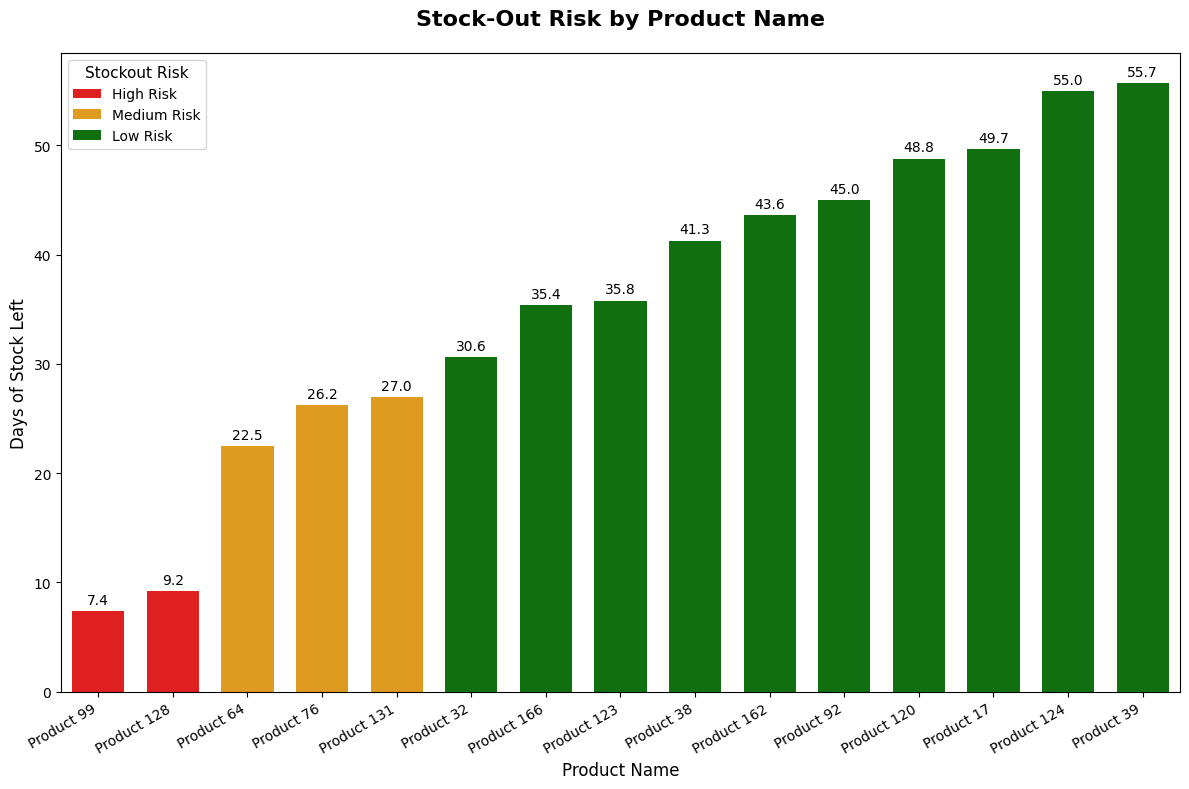

In [5]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=demand_trend.head(15),
    x="item_name",
    y="days_of_stock_left",
    hue="stockout_risk",
    palette=sns.blend_palette(["red", "orange", "green"], n_colors=3),
    width=0.7,
)

# Add labels to the plot
plt.title("Stock-Out Risk by Product Name", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Product Name", fontsize=12)
plt.ylabel("Days of Stock Left", fontsize=12)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3, fontsize=10)

# Rotate x-axis labels
plt.xticks(rotation=30, ha="right")

# Adjust legend
plt.legend(title="Stockout Risk", title_fontsize=11, fontsize=10, loc="upper left")

plt.tight_layout()
plt.show()

##### Insights:

1. Product 99 and Product 128 has less than 10 days of stock. Putting them in high stock out risk.

2. Product 64, Product 131 and Product 76 fall under medium risk, with stock ranging 22–27 days.

3. These SKU's are likely fast-moving or inaccurately forecasted, needs immidiate procurement.

4. Wide variation from 8 to 66 days showing inefficient stock planning and inconsistent stock planing.

#### Q2. How much inventory value is tied up in slow-moving or dead stock?

In [6]:
sql_q2 = """
WITH
    inventory_value AS (
        SELECT
            inv.item_id,
            inv.current_stock * inv.unit_cost AS stock_value,
            MAX(sls.sale_date) AS sale_date
        FROM
            sales sls
            JOIN inventory inv ON inv.item_id = sls.item_id
        GROUP BY
            inv.item_id
    ),
    inventory_value_status AS (
        SELECT
            item_id,
            stock_value,
            sale_date,
            CASE
                WHEN sale_date <= '2025-03-31' THEN 'Slow Moving Stock'
                ELSE 'Fast Moving Stock'
            END AS stock_status
        FROM
            inventory_value
    )
SELECT
    stock_status,
    ROUND(SUM(stock_value) / 1000000, 2) AS stock_value_mn
FROM
    inventory_value_status
GROUP BY
    stock_status;
"""

inventory_value = pd.read_sql(sql=sql_q2, con=engine)
inventory_value

,stock_status,stock_value_mn
0,Slow Moving Stock,23.61
1,Fast Moving Stock,194.64


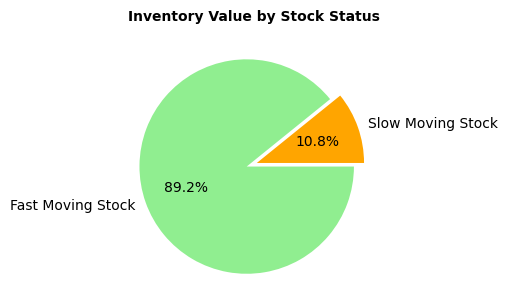

In [7]:
# Using pie chart to show the proportion of stock status in warehouse

plt.figure(figsize=(5, 5))
plt.pie(
    data=inventory_value,
    x="stock_value_mn",
    labels="stock_status",
    autopct="%1.1f%%",
    explode=(0, 0.1),
    colors=["orange", "lightgreen"],
)
plt.title("Inventory Value by Stock Status ", fontsize=10, weight="bold")
plt.tight_layout()
plt.show()

##### Insights :
1. 89.2% of stock which is fast moving, could be due to low price, essential products which is used in day to day life or popularity of the brands among the customers.
2. 10.8% stock is identified as slow moving, In this category the products are more likely to be luxury goods or seasonal. 

3. In slow moving stock we have to identify why these products stuck at the warehouse and plan inventory accordingly.

#### Q3. Which SKUs are approaching expiry and require priority action?

In [8]:
# Here '2025-06-30' is used as today's date.

sql_q3 = """
WITH
    product_expiry AS (
        SELECT
            item_id,
            item_name,
            ROUND((current_stock * unit_cost)/1000000,2) AS inventory_value_m,
            date_expiry,
            (date_expiry - '2025-06-30') AS days_in_expiry
        FROM
            inventory
    )
SELECT
    item_id,
    item_name,
    inventory_value_m,
    date_expiry,
    days_in_expiry,
    CASE
        WHEN days_in_expiry < 0 THEN 'Expired'
        WHEN days_in_expiry <= 30 THEN 'High Risk'
        WHEN days_in_expiry <= 90 THEN 'Medium Risk'
        WHEN days_in_expiry <= 180 THEN 'Low Risk'
        ELSE 'Safe'
    END AS expiry_status
FROM
    product_expiry
ORDER BY
    days_in_expiry;
"""

expiry_status = pd.read_sql(sql=sql_q3, con=engine)
expiry_status.head()

,item_id,item_name,inventory_value_m,date_expiry,days_in_expiry,expiry_status
0,SKU_0053,Product 53,0.47,2025-07-01,1,High Risk
1,SKU_0021,Product 21,3.41,2025-07-01,1,High Risk
2,SKU_0032,Product 32,0.02,2025-07-02,2,High Risk
3,SKU_0051,Product 51,1.25,2025-07-03,3,High Risk
4,SKU_0030,Product 30,1.21,2025-07-04,4,High Risk


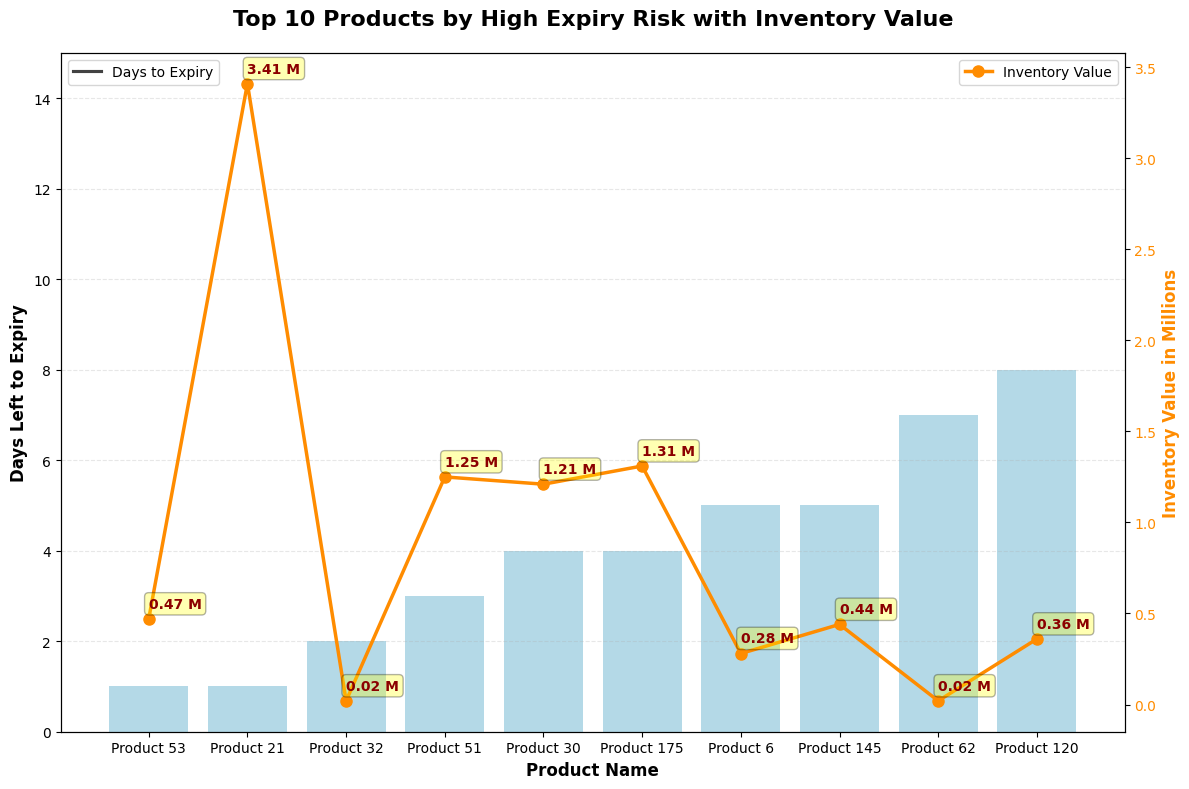

In [9]:
plt.figure(figsize=(12, 8))

# Bar plot for days to expiry
ax = sns.barplot(
    data=expiry_status.head(10),
    x="item_name",
    y="days_in_expiry",
    color="skyblue",
    alpha=0.7,  # Add transparency for better layering
)

# Titles and labels
plt.title(
    "Top 10 Products by High Expiry Risk with Inventory Value",
    fontsize=16,
    fontweight="bold",
    pad=20,  # Add padding above title
)
ax.set_xlabel("Product Name", fontsize=12, fontweight="bold")
ax.set_ylabel("Days Left to Expiry", fontsize=12, fontweight="bold")
ax.set_ylim(0, 15)
ax.grid(axis="y", alpha=0.3, linestyle="--")  # Add subtle gridlines

# Second axis for inventory value
ax2 = ax.twinx()
y_vals = expiry_status.head(10)["inventory_value_m"]

# Use numeric positions for proper alignment
line = ax2.plot(
    range(len(y_vals)),
    y_vals,
    marker="o",
    markersize=8,
    linestyle="-",
    linewidth=2.5,
    color="darkorange",
    label="Inventory Value",
)
ax2.set_ylabel(
    "Inventory Value in Millions", fontsize=12, fontweight="bold", color="darkorange"
)
ax2.tick_params(axis="y", labelcolor="darkorange")

# Add value labels with better positioning
for i, y in enumerate(y_vals):
    ax2.annotate(
        f"{y:,.2f} M",  # Format with comma separator
        xy=(i, y),
        xytext=(0, 8),  # Offset above point
        textcoords="offset points",
        ha="left",
        fontsize=10,
        color="darkred",
        fontweight="bold",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3
        ),  # Background box
    )

# Add legend
ax.legend(["Days to Expiry"], loc="upper left")
ax2.legend(["Inventory Value"], loc="upper right")

plt.tight_layout()
plt.show()

##### Insights:

1. Product 21, Product 175, Product 30 and Product 51 has very high value 3.41M, 1.31M, 1.25M and 1.21M but less than 4 days left to expiry date, making them highest financial risk.

2. These products have very low remaining shelf life with high cost. Urgent action required like discount offers, bundle promotions, clearance offers or return to vendor.

3. There are some products with low value and about to expire soon. These products do not cause financial risk but shrinking warehouse storage capacity.

#### Q4. What is the current inventory turnover rate, and which categories perform the best or worst?

In [10]:
sql_q4 = """
WITH
    sales_cogs AS (
        SELECT
            inv.item_id,
            inv.category,
            inv.current_stock * inv.unit_cost AS inventory_value,
            SUM(sls.sold_qty * inv.unit_cost) AS cogs
        FROM
            inventory inv
            JOIN sales sls ON (sls.item_id = inv.item_id)
        GROUP BY
            inv.item_id,
            inv.category
    ),
    inventory_turnover_per_item AS (
        SELECT
            item_id,
            category,
            inventory_value,
            cogs,
            ROUND(cogs / inventory_value, 2) AS inventory_turnover_rate
        FROM
            sales_cogs
    )
SELECT
    category,
    ROUND(AVG(inventory_turnover_rate), 2) AS inventory_turnover_rate
FROM
    inventory_turnover_per_item
GROUP BY
    category;
"""

inventory_turnover = pd.read_sql(sql=sql_q4, con=engine)
inventory_turnover

,category,inventory_turnover_rate
0,Electronics,3.13
1,Food,3.76
2,Household,3.49
3,Pharma,2.57
4,Automotive,2.85


In [11]:
print(
    f"Overall Inventory Turnover Rate {round(inventory_turnover["inventory_turnover_rate"].mean(),2)}"
)

Overall Inventory Turnover Rate 3.16


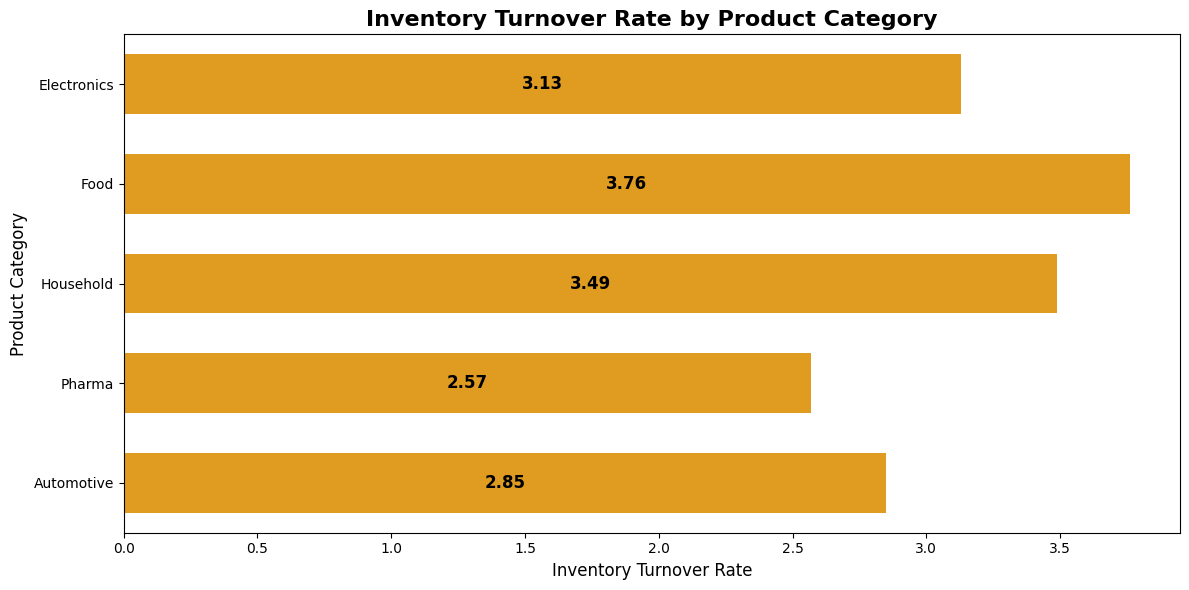

In [12]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=inventory_turnover,
    x="inventory_turnover_rate",
    y="category",
    color="orange",
    width=0.6,
)

# Add bar labels at the center of each bar
for i, bar in enumerate(ax.patches):
    width = bar.get_width()
    ax.text(
        width / 2,  # Position at the middle of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically
        f"{width:.2f}",  # Format to 2 decimal places
        ha="center",  # Center alignment horizontally
        va="center",  # Center alignment vertically
        fontsize=12,
        fontweight="bold",
        color="black",  # White text for contrast against orange
    )

plt.title("Inventory Turnover Rate by Product Category", fontsize=16, fontweight="bold")
plt.xlabel("Inventory Turnover Rate", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.tight_layout()
plt.show()

##### Insights :

1. Food & Household performing best when compare to rest of the other categories. It's high turnover rate 3.76 & 3.49 indicates strong demand and efficient stock movement.

2. Worst Performing category is Pharma in all the categories with turnover rate 2.57. Capital is tied up in these category with high carrying cost and risk of expiry.

3. Low turnover rate suggest that these product more likely to sit in warehouse for longer time compared to other categories.

4. Overall Inventory Turnover Rate is 3.16.

#### Q5. Which suppliers have the most inconsistent lead times or poor delivery performance?

In [13]:
sql_q5 = """
WITH
    supplier_performance AS (
        SELECT
            spl.supplier_id,
            spl.supplier_name,
            COUNT(pod.*) AS no_of_purchase_order,
            ROUND(AVG(pod.received_date - pod.order_date), 2) AS avg_lead_time_days
        FROM
            purchase_orders pod
            JOIN suppliers spl ON (pod.supplier_id = spl.supplier_id)
        GROUP BY
            spl.supplier_id,
            spl.supplier_name
    )
SELECT
    supplier_name,
    no_of_purchase_order,
    avg_lead_time_days,
    CASE
        WHEN avg_lead_time_days <= 5 THEN 'Good'
        WHEN avg_lead_time_days <= 10 THEN 'Moderate'
        ELSE 'Poor'
    END AS Performance_status
FROM
    supplier_performance
ORDER BY
    avg_lead_time_days;
"""

supplier_performance = pd.read_sql(sql=sql_q5, con=engine)
supplier_performance.head()

,supplier_name,no_of_purchase_order,avg_lead_time_days,performance_status
0,Tucker Group,150,7.04,Moderate
1,Ryan-Nelson,29,7.17,Moderate
2,Jones Inc,28,7.32,Moderate
3,Conner-Douglas,5,7.60,Moderate
4,Martinez Ltd,153,7.67,Moderate


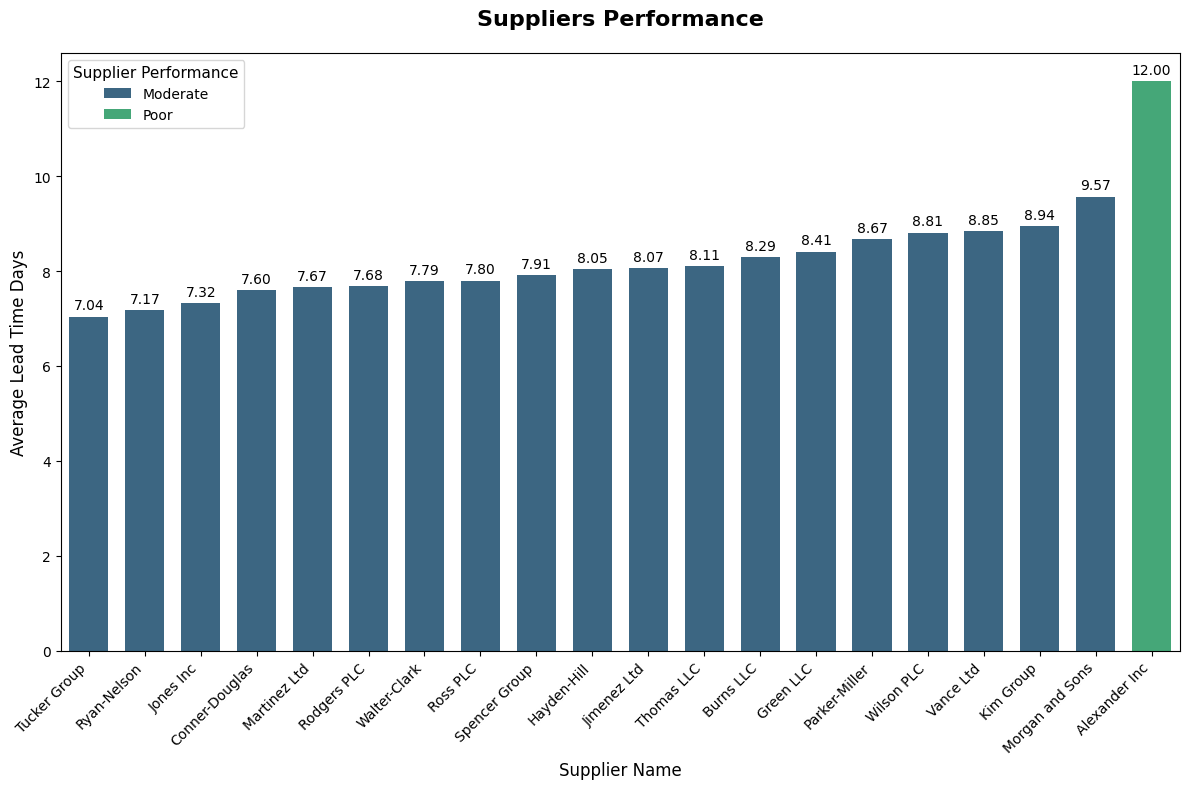

In [14]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=supplier_performance,
    x="supplier_name",
    y="avg_lead_time_days",
    hue="performance_status",
    palette="viridis",
    width=0.7,
)

# Add labels to the plot
plt.title("Suppliers Performance", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Supplier Name", fontsize=12)
plt.ylabel("Average Lead Time Days", fontsize=12)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right")

# Adjust legend
plt.legend(
    title="Supplier Performance", title_fontsize=11, fontsize=10, loc="upper left"
)

plt.tight_layout()
plt.show()

##### Insights :

1. Tucker Group has the lowest average delivery time 7.04 days. Ideal for urgent procurement, fast moving goods and stock out prevention strategy.

2. Alexander Inc has the highest average delivery time 12 days. Indicating high risk of stock outs, delayed orders and customer dessatisfaction.

3. Rest of the supplier has the average delivery time ranging between 7-9 days. These suppliers are good for reguler replenishment, but not for high demand or urgent products.

>### Key Insights

1. 4% of inventory have high to moderate stock-out risk.

2. 10.8% inventory is tied up in slow moving stock or dead stock.

3. Some products are going to expire within 10 days with value 8.77M rupee.

4. Food category has best 3.76 inventory turnover rate while Pharma and Automotive has worst 2.57.

5. Supplier Alexander Inc has un-reliable lead time, indicating risk of delayed replenishment.

>### Recommendation

1. maintain stable stock levels for high demand and fast-moving SKU's to reduce stock out risk and maintain healthy stock levels.

2. liquidate slow moving or dead stock through bundling, discounts and clearance sales and stop routine procurement of these type of stocks.

3. Promote discount schemes for near expiry products to reduce financial loss. Apply FIFO or FEFO method to sell older product before new one.

4. Increase procurement frequency for high inventory turnover categories to maintain product availablity.

5. Avoid overstocking for low inventory turnover categories to save storage space and storage cost.

6. Engage with underperforming suppliers with long and inconsistant lead time for escalation and contact negotiation and shift critical products to suppliers with low or stable lead time.